<a href="https://colab.research.google.com/github/JV456/PyTorch/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making classification data and getting it ready

In [69]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [70]:
print(f"First 5 X features: {X[:5]}")
print(f"\nFirst 5 y labels: {y[:5]}")

First 5 X features: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels: [1 1 1 1 0]


In [71]:
# making dataframe

import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
    "X2": X[:,1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [72]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

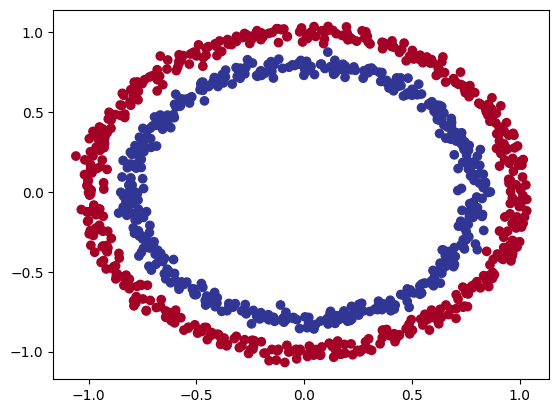

In [73]:
# we will now visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [74]:
# lets check the shape of our features and labels
X.shape , y.shape

((1000, 2), (1000,))

In [75]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


#  Turning data into tensors and create train and test splits

In [76]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building a model

In [78]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [79]:
# constructing the model

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [80]:
# replicating CircleModelV1 with nn.Sequential

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [81]:
# making predictions with the model

untrained_preds = model_1(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0477],
        [ 0.1137],
        [-0.4259],
        [ 0.0593],
        [-0.3548],
        [-0.2569],
        [ 0.1411],
        [ 0.0545],
        [-0.4283],
        [ 0.1253]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Setting up loss function and optimizer

In [82]:
# creating the loss function
loss_fn = nn.BCEWithLogitsLoss()

# creating an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)


In [83]:
# creting a evaluation matrix

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

# Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [84]:
y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[-0.0477],
        [ 0.1137],
        [-0.4259],
        [ 0.0593],
        [-0.3548]], device='cuda:0', grad_fn=<SliceBackward0>)

In [85]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4881],
        [0.5284],
        [0.3951],
        [0.5148],
        [0.4122]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [86]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [87]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

# Building a training and testing loop

In [88]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  ## training

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  ## testing

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # for every 10 epochs

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test_loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70277, Accuracy: 47.88% | Test_loss: 0.71196, Test_acc: 46.50%
Epoch: 10 | Loss: 0.69797, Accuracy: 49.00% | Test_loss: 0.70705, Test_acc: 47.50%
Epoch: 20 | Loss: 0.69637, Accuracy: 49.75% | Test_loss: 0.70476, Test_acc: 47.00%
Epoch: 30 | Loss: 0.69560, Accuracy: 50.12% | Test_loss: 0.70325, Test_acc: 46.50%
Epoch: 40 | Loss: 0.69512, Accuracy: 50.38% | Test_loss: 0.70209, Test_acc: 47.50%
Epoch: 50 | Loss: 0.69477, Accuracy: 50.50% | Test_loss: 0.70115, Test_acc: 47.50%
Epoch: 60 | Loss: 0.69450, Accuracy: 50.38% | Test_loss: 0.70037, Test_acc: 47.50%
Epoch: 70 | Loss: 0.69429, Accuracy: 50.62% | Test_loss: 0.69972, Test_acc: 48.00%
Epoch: 80 | Loss: 0.69411, Accuracy: 50.25% | Test_loss: 0.69917, Test_acc: 48.50%
Epoch: 90 | Loss: 0.69397, Accuracy: 50.25% | Test_loss: 0.69870, Test_acc: 49.00%


# Making predictions and evaluating the model

In [89]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


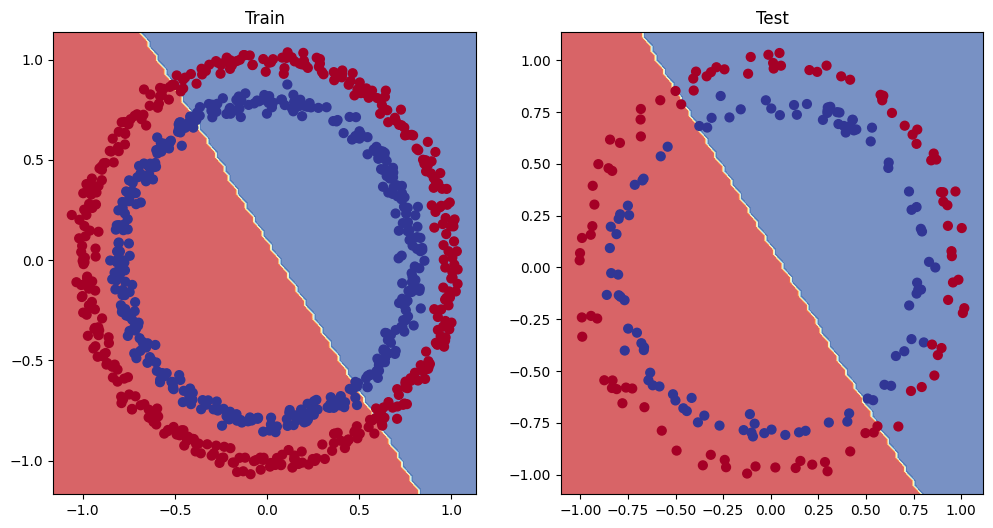

In [90]:
# Ploting decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Improving a model

In [91]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV2().to(device)
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [92]:
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [93]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  ## training

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  ## testing

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # for every 10 epochs

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test_loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test_loss: 0.69261, Test_acc: 51.00%
Epoch: 10 | Loss: 0.69369, Accuracy: 50.25% | Test_loss: 0.69270, Test_acc: 50.00%
Epoch: 20 | Loss: 0.69351, Accuracy: 50.12% | Test_loss: 0.69283, Test_acc: 49.50%
Epoch: 30 | Loss: 0.69339, Accuracy: 50.50% | Test_loss: 0.69297, Test_acc: 48.00%
Epoch: 40 | Loss: 0.69329, Accuracy: 50.38% | Test_loss: 0.69310, Test_acc: 49.00%
Epoch: 50 | Loss: 0.69322, Accuracy: 49.88% | Test_loss: 0.69324, Test_acc: 50.00%
Epoch: 60 | Loss: 0.69317, Accuracy: 49.38% | Test_loss: 0.69336, Test_acc: 51.50%
Epoch: 70 | Loss: 0.69312, Accuracy: 49.38% | Test_loss: 0.69348, Test_acc: 50.50%
Epoch: 80 | Loss: 0.69309, Accuracy: 50.12% | Test_loss: 0.69359, Test_acc: 50.00%
Epoch: 90 | Loss: 0.69307, Accuracy: 50.50% | Test_loss: 0.69370, Test_acc: 48.50%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test_loss: 0.69379, Test_acc: 48.00%
Epoch: 110 | Loss: 0.69303, Accuracy: 50.88% | Test_loss: 0.69388, Test_acc: 46.50%
Epo

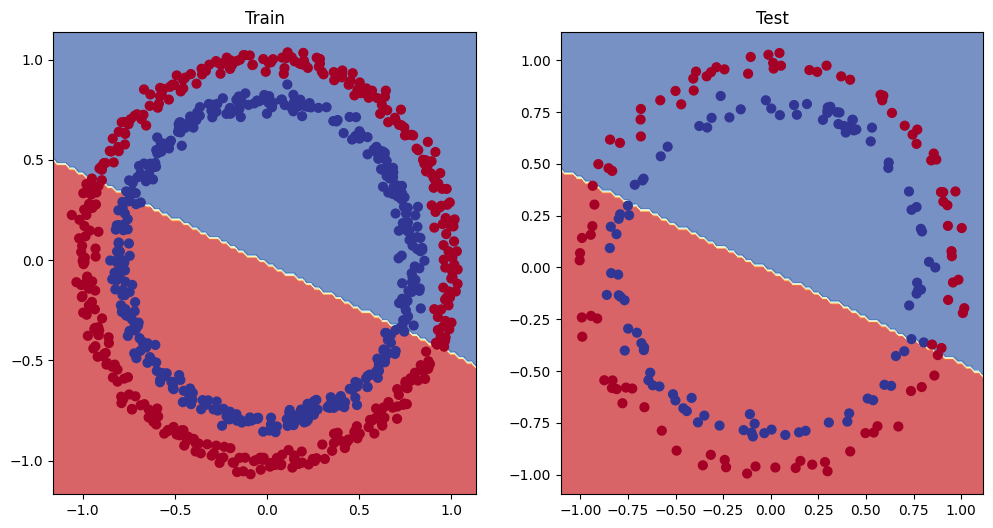

In [94]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)